In [ ]:
# Imports
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
# Constants

# categories map
CATEGORY_DICT = {0: "All", 1: "Acoustic", 2: "Chill", 3: "Dance", 4: "Happy", 5: "Loud", 6: "A Capella", 7: "Alternative", 8: "Blues", 9: "Classical", 10: "Country", 11: "Dance", 12: "Electronic", 13: "Folk", 14: "Hip-Hop", 15: "Indie", 16: "Jazz", 17: "Movie", 18: "Opera", 19: "Pop", 20: "R&B", 21: "Rap", 22: "Reggae", 23: "Reggaeton", 24: "Rock", 25: "Ska", 26: "Soul", 27: "Soundtrack", 28: "World"}

# All dataset paths
path_all = "/content/SpotifyFeatures_Cleaned.csv" 
path_acoustic = "/content/SpotifyFeatures_Cleaned_Acoustic.csv"
path_chill = "/content/SpotifyFeatures_Cleaned_Chill.csv"
path_dance = "/content/SpotifyFeatures_Cleaned_Dance.csv"
path_happy = "/content/SpotifyFeatures_Cleaned_Happy.csv"
path_loud = "/content/SpotifyFeatures_Cleaned_Loud.csv"

In [ ]:
# Helper Methods
def get_data(csv_path:str)->pd.DataFrame:
  """
    Return a pd.DataFrame for the csv at csv_path
  """
  df = pd.read_csv(csv_path)
  if "Unnamed: 0" in df.columns:
    df = df.drop(["Unnamed: 0"], axis = 1)
  if "cluster" in df.columns:
    df = df.drop(["cluster"], axis = 1)
  return df

def select_data(category:int)->pd.DataFrame:
  """
    Return the data set corresponds to the category number in the CATEGORY_DICT
  """
  if category == 1:
    return get_data(path_acoustic)
  elif category == 2:
    return get_data(path_chill)
  elif category == 3:
    return get_data(path_dance)
  elif category == 4:
    return get_data(path_happy)
  elif category == 5:
    return get_data(path_loud)
  elif category > 5 and category < 29:
    genre = CATEGORY_DICT[category]
    data_all = get_data(path_all)
    return data_all[data_all["genre"] == genre]
  else:
    return get_data(path_all)

def predict_popularity(input_song:pd.DataFrame)->float:
  """
    Predict the popularity of the song using xxx model.
  """
  # Get data 
  data = get_data(path_all)

  # Min max scale data
  scaler = MinMaxScaler()
  num_data = data.select_dtypes(exclude=['object'])
  num_data = num_data.drop(['popularity'], axis=1)
  scaler = scaler.fit(num_data)
  data = data.drop(num_data.columns, axis=1)
  data[num_data.columns] = scaler.transform(num_data)

  # Min max scale input song
  num_input_song = input_song.select_dtypes(exclude=['object'])
  num_input_song = num_input_song.drop(['popularity'], axis=1)
  input_song = input_song.drop(num_input_song.columns, axis=1)
  input_song[num_input_song.columns] = scaler.transform(num_input_song)

  # Get X and y
  X = data._get_numeric_data().drop(['popularity'], axis=1)
  y = data['popularity'].values.reshape(-1, 1)

  # Input to predict
  test_input = input_song._get_numeric_data().drop(['popularity'], axis=1)

  # Model fitting
  poly = PolynomialFeatures(degree=4)
  ploy_reg = LinearRegression().fit(poly.fit_transform(X), y)

  # Predicting
  predict_popularity = ploy_reg.predict(poly.fit_transform(test_input)).item()

  return predict_popularity

def radar_top_n_song_features(input_song:pd.DataFrame, category:int, n:int):
  """
  Input: 
    input_song: a pd.DataFrame of listener input song, the order of the columns should be 
                'track_id', 'popularity', 'acousticness', 'danceability', 'liveness',
                'loudness', 'speechiness', 'tempo', 'valence', 'genre', 'artist_name',
                'track_name'

    category: an integer representing the category the listener choose, see what each number 
              corresponds to in the CATEGORY_DICT

    n: number of most popular songs

  Output:
    Plot a radar plot of the mean audio features of the most popular n songs in the category
  """
  # Fix n to be < 10000
  if n > 10000:
    print("We only process top 10000 songs at this category.")
    n = 10000

  # Select the correct data set
  data = select_data(category)

  # Get category name
  category_name = CATEGORY_DICT[category]

  # Min max scale data
  scaler = MinMaxScaler()
  num_data = data.select_dtypes(exclude=['object'])
  num_data = num_data.drop(['popularity'], axis=1)
  scaler = scaler.fit(num_data)
  data = data.drop(num_data.columns, axis=1)
  data[num_data.columns] = scaler.transform(num_data)

  # Min max scale input song
  num_input_song = input_song.select_dtypes(exclude=['object'])
  num_input_song = num_input_song.drop(['popularity'], axis=1)
  input_song = input_song.drop(num_input_song.columns, axis=1)
  input_song[num_input_song.columns] = scaler.transform(num_input_song)

  # Top n number of songs 
  data_top_songs = data.nlargest(n, 'popularity')

  # Mean features of top songs
  data_top_songs_mean = data_top_songs._get_numeric_data().drop(["popularity"], axis=1).mean()

  # Each attribute we'll plot in the radar chart.
  labels = data_top_songs_mean.index.tolist()

  # Values to plot
  data_values = data_top_songs_mean.values.tolist()
  input_values = input_song._get_numeric_data().drop(["popularity"], axis=1).values.flatten().tolist()

  # Number of variables we're plotting.
  num_vars = len(labels)

  # Split the circle into even parts and save the angles
  # so we know where to put each axis.
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

  # The plot is a circle, so we need to "complete the loop"
  # and append the start value to the end.
  data_values += data_values[:1]
  input_values += input_values[:1]
  angles += angles[:1]

  # ax = plt.subplot(polar=True)
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

  plot_label_data = f"The Mean Audio Features of the Top {n} {category_name} Songs"
  plot_label_input_song = f"The Audio Features of \"{input_song['track_name'].values.tolist()[0]}\" by \"{input_song['artist_name'].values.tolist()[0]}\""

  # Draw the outline of our data.
  ax.plot(angles, data_values, color='#1DB954', linewidth=1, label=plot_label_data)
  # Fill it in.
  ax.fill(angles, data_values, color='#1DB954', alpha=0.75)
  # Draw the outline of our data.
  ax.plot(angles, input_values, color='#191414', linewidth=1, label=plot_label_input_song)
  # Fill it in.
  ax.fill(angles, input_values, color='#191414', alpha=0.5)

  # Fix axis to go in the right order and start at 12 o'clock.
  ax.set_theta_offset(np.pi / 2)
  ax.set_theta_direction(-1)

  # Draw axis lines for each angle and label.
  ax.set_thetagrids(np.degrees(angles), labels, fontsize=16)
  #ax.set_title(f'{plot_label_input_song} vs. {plot_label_data}', y=1.2, fontsize=16)
  ax.legend(loc='upper right', bbox_to_anchor=(2.5, 1.2), fontsize=16)

In [ ]:
# Main
def main_artist(input_song:pd.DataFrame, category:int, n:int):
  """
  Input: 
    input_song: a pd.DataFrame of listener input song, the order of the columns should be 
                'track_id', 'popularity', 'acousticness', 'danceability', 'liveness',
                'loudness', 'speechiness', 'tempo', 'valence', 'genre', 'artist_name',
                'track_name'

    category: an integer representing the category the listener choose, see what each number 
              corresponds to in the CATEGORY_DICT

    n: number of most popular songs

  Output:
    Return the predicted popularity of the song
    Plot a radar plot of the mean audio features of the most popular n songs in the category
  """
  # Predict popularity
  popularity = predict_popularity(input_song)

  # Radar plot input with top songs from select category
  radar_top_n_song_features(input_song, category, n)

  return popularity


In [ ]:
data

,track_id,popularity,genre,artist_name,track_name,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
0,000CzNKC8PEt1yC3L8dqwV,5.0,Movie,Henri Salvador,Coeur Brisé à Prendre - Remastered,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841
1,000DfZJww8KiixTKuk9usJ,30.0,Reggae,Mike Love,Earthlings,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307
2,000EWWBkYaREzsBplYjUag,39.0,Jazz,Don Philippe,Fewerdolr,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560
3,000xQL6tZNLJzIrtIgxqSl,70.0,Dance,ZAYN,Still Got Time,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524
4,001KkOBeRiQ1J7IEJYHODW,31.0,World,C3 Music,The Father's Love - Live,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110
...,...,...,...,...,...,...,...,...,...,...,...,...
142678,7zz3cHALU9cj7Io5qINt1R,21.0,World,Hillsong Worship,Emmanuel,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287
142679,7zz7MbCb9G7KJc1NVl9bL0,38.0,Jazz,Caravan Palace,Maniac,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889
142680,7zzFNNxVD0h0ctAT08H0pa,40.0,Jazz,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110
142681,7zzTeItz93lYI52hlcipm5,28.0,Reggaeton,Magnate Y Valentino,Una En Un Millón,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544


In [ ]:
data = select_data(0)
scaler = MinMaxScaler()
num_data = data.select_dtypes(exclude=['object'])
num_data = num_data.drop(['popularity'], axis=1)
scaler = scaler.fit(num_data)
data = data.drop(num_data.columns, axis=1)
data[num_data.columns] = scaler.transform(num_data)
data.describe()

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
count,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000
mean,39.681628,0.384517,0.520136,0.186389,0.782604,0.067923,0.416157,0.441665
std,16.901008,0.364767,0.211773,0.170048,0.122296,0.101174,0.148100,0.270136
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.042017,0.373186,0.087173,0.735197,0.015168,0.296612,0.206000
50%,41.000000,0.247991,0.541985,0.114437,0.823156,0.026941,0.406246,0.425000
75%,51.000000,0.756024,0.683905,0.228540,0.867233,0.068838,0.520984,0.661000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Some example outputs using input_song = "Migraine" by "Moonstar88"

Predicted popularity out of 100:  48.99775335277552


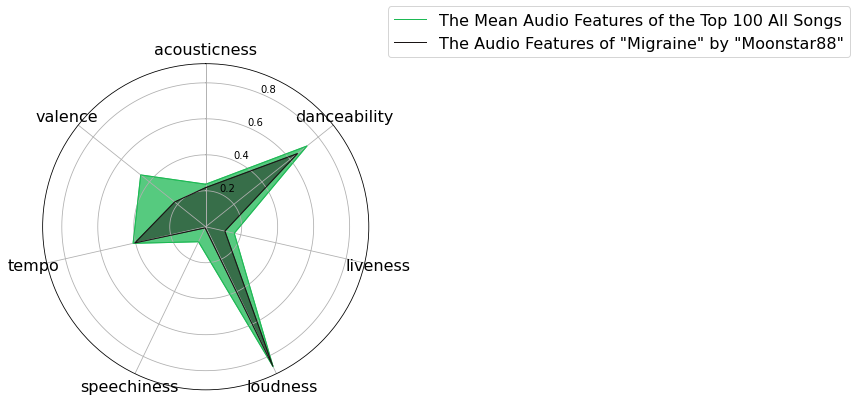

In [ ]:
input_song = get_data(path_all).tail(1).copy()
n = 100
category = 0

popularity = main_artist(input_song, category, n)
print("Predicted popularity out of 100: ", popularity)

We only process top 10000 songs at this category.
Predicted popularity out of 100:  48.99775335277552


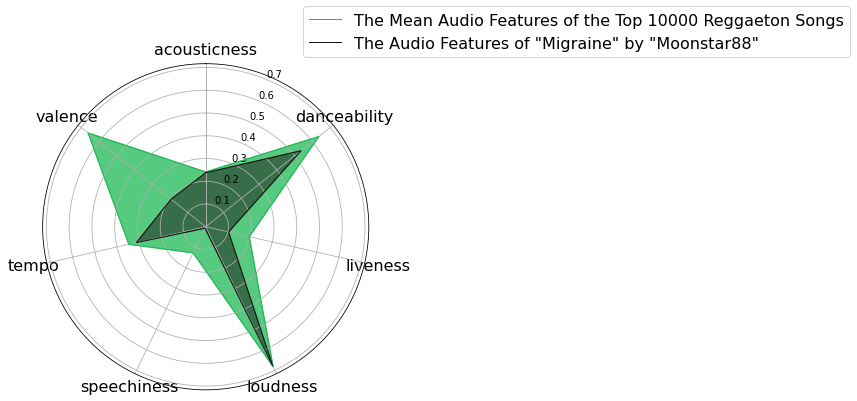

In [ ]:
input_song = get_data(path_all).tail(1).copy()
n = 100000
category = 23

popularity = main_artist(input_song, category, n)
print("Predicted popularity out of 100: ", popularity)

Predicted popularity out of 100:  48.99775335277552


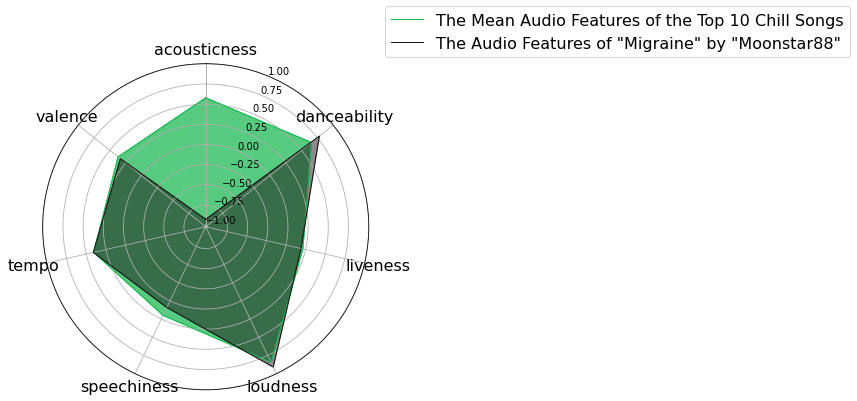

In [ ]:
input_song = get_data(path_all).tail(1).copy()
n = 10
category = 2

popularity = main_artist(input_song, category, n)
print("Predicted popularity out of 100: ", popularity)